# CO VIDIS ? 

*Co Vidis ?, latin for "COVID-19, where are you going?"*

Daily update of the state of Coronavirus around Switzerland. 

- **Author** : Fred Montet (https://twitter.com/fredmontet)
- **Repository** : https://github.com/fredmontet/co-vidis
- **Data Source** : https://github.com/CSSEGISandData/COVID-19


## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%config InlineBackend.figure_format ='retina'

# The command to generate the HTML
# jupyter nbconvert covid-19.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --TagRemovePreprocessor.remove_input_tags='{"remove_input"}'

## Functions

In [2]:
def create_by_country_dataframe(df):
    by_country = df.T
    by_country.columns = by_country.loc["Country/Region"]
    by_country = by_country[4:]
    by_country = by_country.groupby(axis=1, by=by_country.columns).sum()
    by_country.index = pd.to_datetime(by_country.index)
    return by_country

def is_it_spreading(df):
    return df.diff()

## Data Loading

In [3]:
data = "../data/raw/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/"

In [4]:
confirmed = f"{data}time_series_19-covid-Confirmed.csv"
deaths = f"{data}time_series_19-covid-Deaths.csv"
recovered = f"{data}time_series_19-covid-Recovered.csv"

In [5]:
df_confirmed = pd.read_csv(confirmed)
df_deaths = pd.read_csv(deaths)
df_recovered = pd.read_csv(recovered)

In [6]:
df = {
    "confirmed": df_confirmed,
    "deaths": df_deaths,
    "recovered": df_recovered
}

## Compute a Index by Country

In [7]:
by_country = {
    "confirmed" : create_by_country_dataframe(df.get("confirmed")),
    "deaths" : create_by_country_dataframe(df.get("deaths")),
    "recovered" : create_by_country_dataframe(df.get("recovered"))
}

Compute the existing cases and add them to the Dictionnary

In [8]:
# Active cases = total confirmed - total recovered - total deaths
by_country["existing"] = by_country["confirmed"] - by_country["recovered"] - by_country["deaths"]

## Regions of Interest

In [9]:
CH = ["Switzerland"]
CH_neighbors = ["Italy", "France", "Liechtenstein", "Austria", "Germany"]
CH_neighbors_no_italy = ["France", "Liechtenstein", "Austria", "Germany"]

# Bulgaria, Cyprus and Romania are not in the list
# Switzerland has been added
EU = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]
EU_no_italy = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]

## Last Update

In [10]:
str(by_country["existing"].iloc[-1].name.date())

'2020-03-11'

## Period of Interest

In [11]:
last_n_days = 14

In [12]:
existing = by_country.get("existing")[-last_n_days:]
confirmed = by_country.get("confirmed")[-last_n_days:]
deaths = by_country.get("deaths")[-last_n_days:]
recovered = by_country.get("recovered")[-last_n_days:]

## Evolution of the Number of Existing Cases

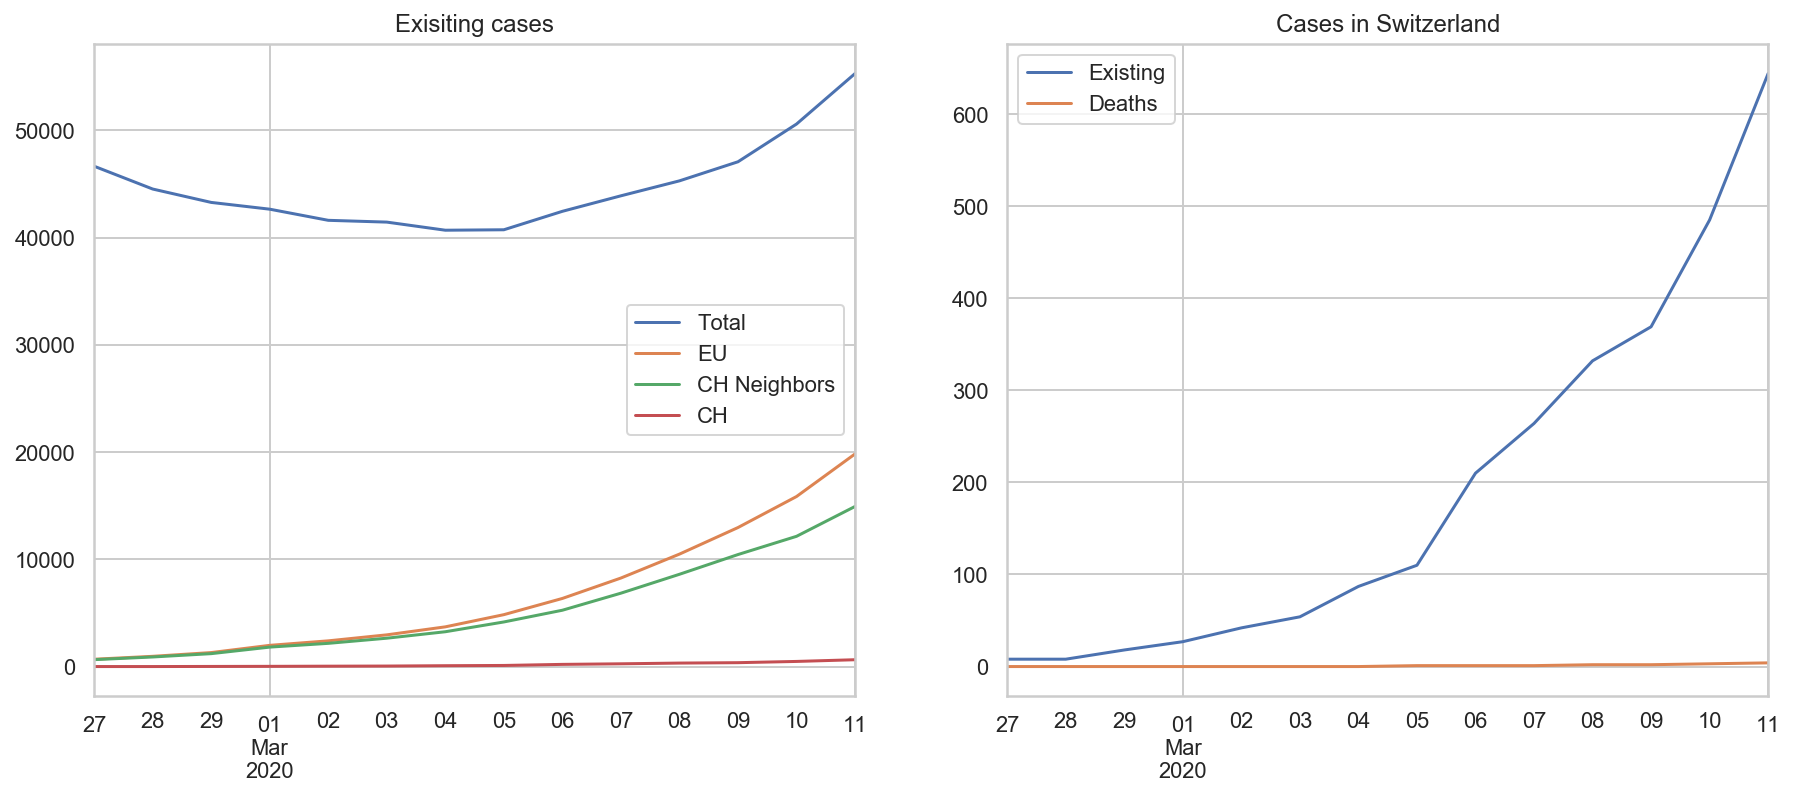

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
existing.sum(axis=1).plot(ax=ax1, figsize=(15,6), title="Exisiting cases")
existing[EU].sum(axis=1).plot(ax=ax1)
existing[CH_neighbors].sum(axis=1).plot(ax=ax1)
existing[CH].sum(axis=1).plot(ax=ax1)

existing[CH].sum(axis=1).plot(ax=ax2, title="Cases in Switzerland")
deaths[CH].sum(axis=1).plot(ax=ax2)

ax1.legend(["Total", "EU", "CH Neighbors", "CH"]);
ax2.legend(["Existing", "Deaths"]);

## Cases Around and with Switzerland

In [14]:
df1 = pd.DataFrame(by_country["existing"][CH_neighbors + CH].iloc[-1].astype(int))
df2 = pd.DataFrame(by_country["deaths"][CH_neighbors + CH].iloc[-1].astype(int))
df1.rename(columns={df1.columns[-1]:"Existing"}, inplace=True)
df2.rename(columns={df2.columns[-1]:"Deaths"}, inplace=True)
df = pd.concat([df1,df2], axis=1)

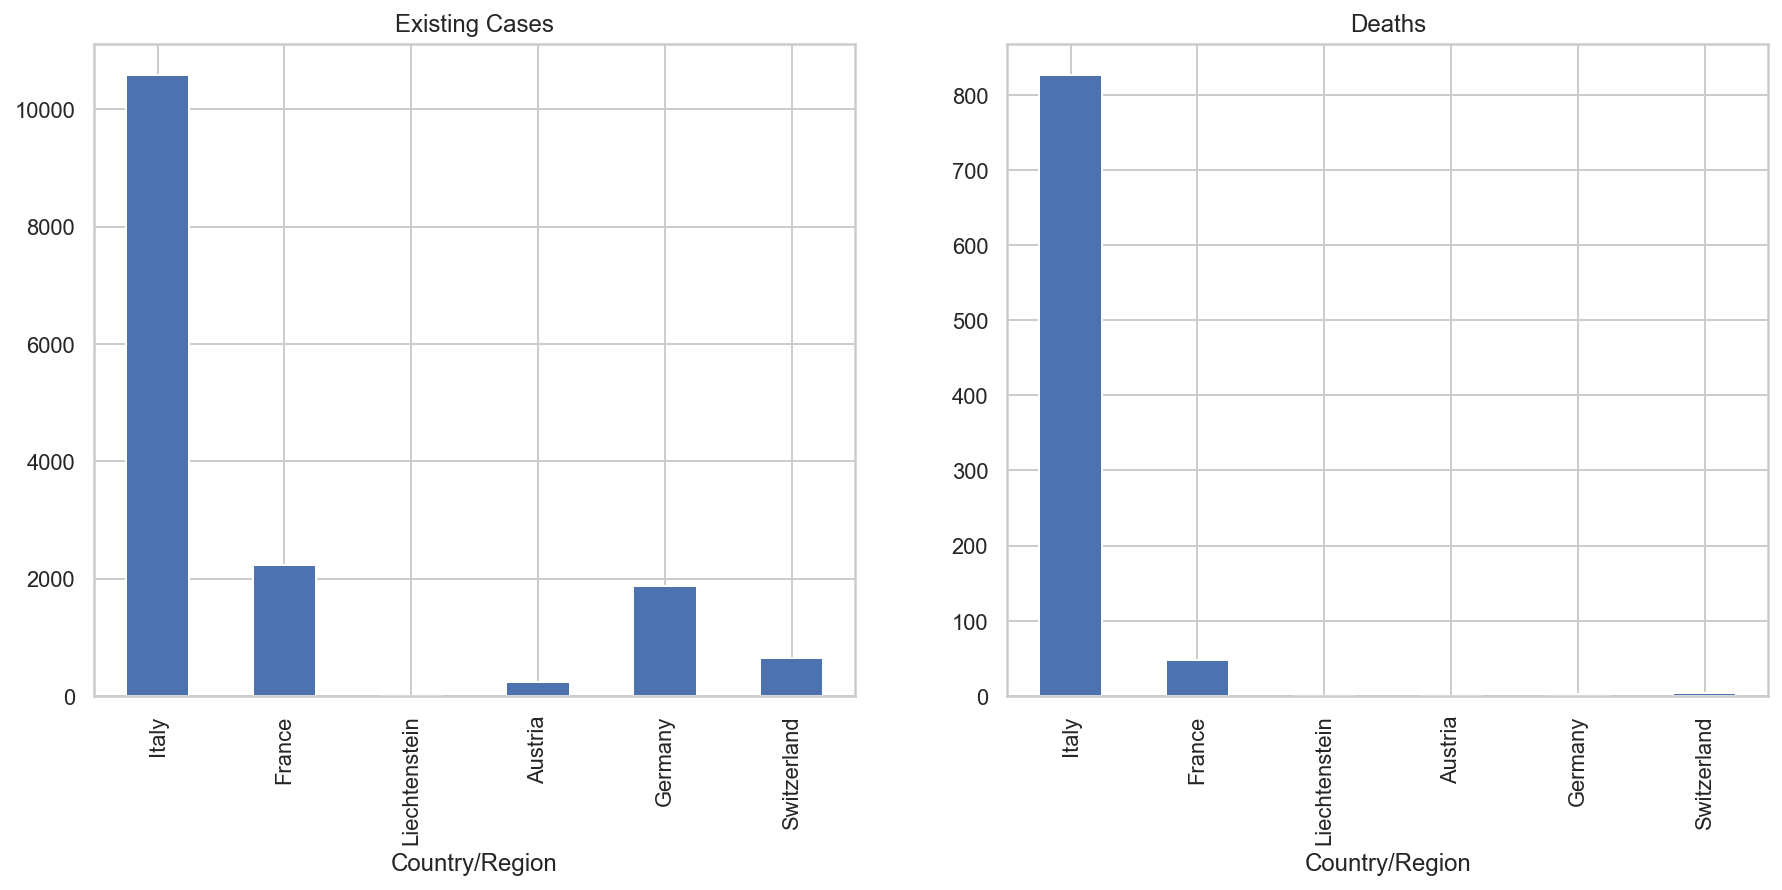

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)
df.Existing.plot.bar(ax=ax1, title="Existing Cases", figsize=(15,6));
df.Deaths.plot.bar(ax=ax2, title="Deaths");

In [16]:
df

,Existing,Deaths
Country/Region,,
Italy,10590,827
France,2224,48
Liechtenstein,1,0
Austria,242,0
Germany,1880,3
Switzerland,644,4


### New Cases per Day

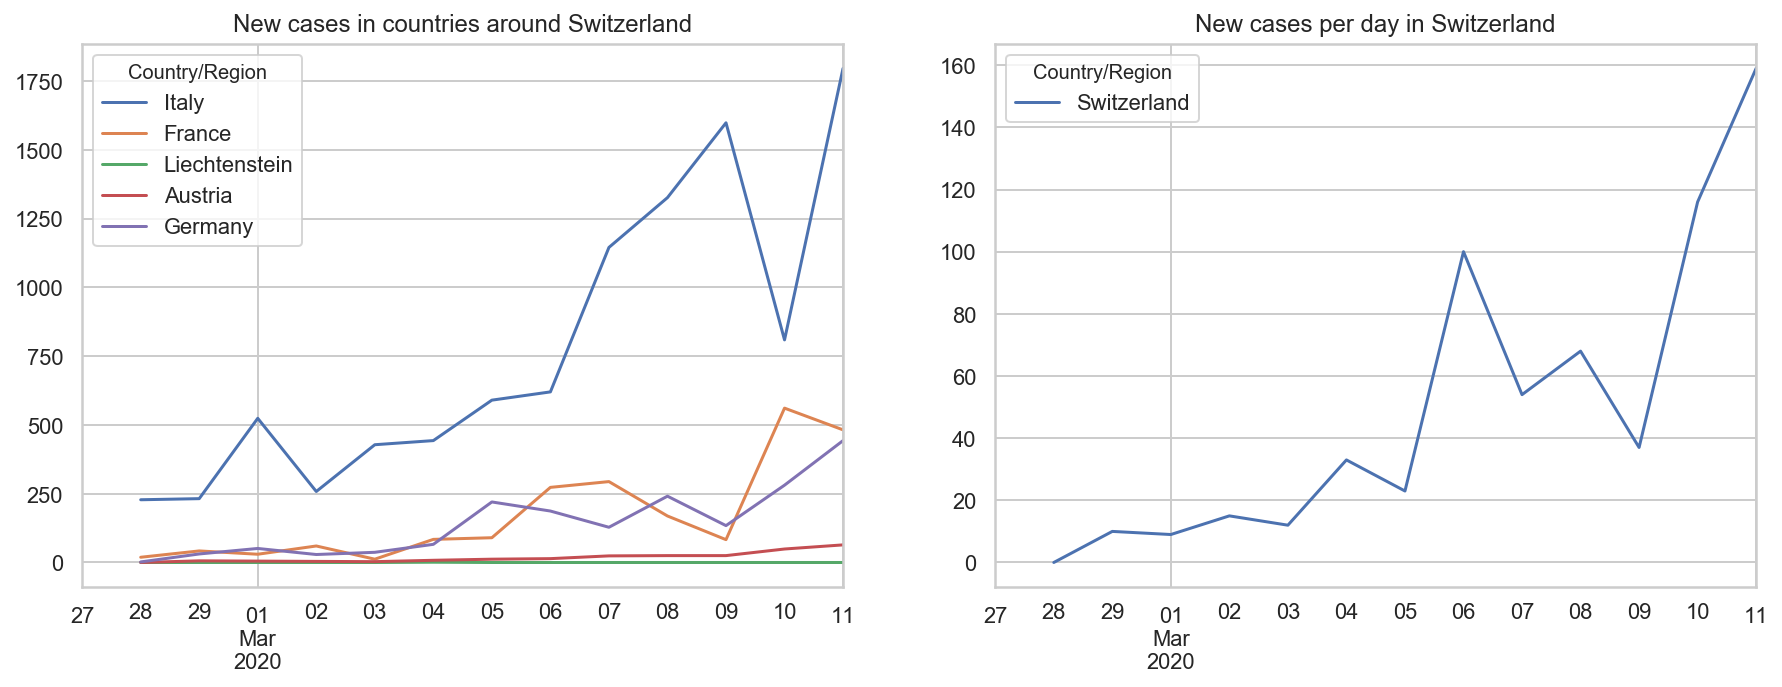

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
existing[CH_neighbors].diff().plot(ax=ax1, figsize=(15,5), title="New cases in countries around Switzerland")
existing[CH].diff().plot(ax=ax2, title="New cases per day in Switzerland");